# Atenção
 Esse notebook não foi executado no google colabotory, por falta de recursos (gpu), foi executado em uma máquina local, mas os parâmetros (pastas) foram mudados para executar no google colab.

In [ ]:
#!unzip /content/dataset-20240808T021407Z-001.zip

# Start

Na procura de melhorar o modelo anterior, utilizei um modelo pré-treinado AlexNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torchvision
import numpy as np
import os
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the pre-trained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
torch.manual_seed(42)

Using cache found in /home/raisler/.cache/torch/hub/pytorch_vision_v0.10.0
/home/raisler/.cache/pypoetry/virtualenvs/remapgeo-HGXh80aR-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raisler/.cache/pypoetry/virtualenvs/remapgeo-HGXh80aR-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

In [ ]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
data_dir = '/content/dataset/train_dataset'
image_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate the sizes of train and test datasets
train_size = int(0.85 * len(image_dataset))
test_size = len(image_dataset) - train_size
# Get the class names
class_names = image_dataset.classes
train_size, test_size

# Split the dataset
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

# Create DataLoaders for the train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=378, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


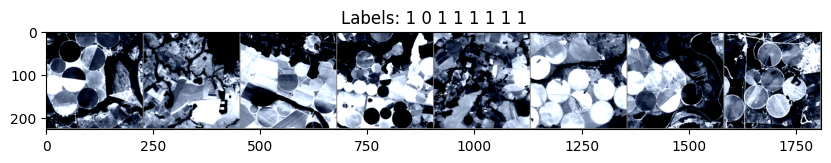

In [ ]:
def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Labels: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))
    plt.show()


# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Call the function to display images
imshow(torchvision.utils.make_grid(images[:8]), labels[:8])

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.3712
Epoch [2/20], Loss: 0.1273
Epoch [3/20], Loss: 0.1177
Epoch [4/20], Loss: 0.0722
Epoch [5/20], Loss: 0.1779
Epoch [6/20], Loss: 0.0574
Epoch [7/20], Loss: 0.0622
Epoch [8/20], Loss: 0.2020
Epoch [9/20], Loss: 0.0283
Epoch [10/20], Loss: 0.0724
Epoch [11/20], Loss: 0.0464
Epoch [12/20], Loss: 0.0756
Epoch [13/20], Loss: 0.0984
Epoch [14/20], Loss: 0.0836
Epoch [15/20], Loss: 0.1321
Epoch [16/20], Loss: 0.0566
Epoch [17/20], Loss: 0.0876
Epoch [18/20], Loss: 0.0163
Epoch [19/20], Loss: 0.0432
Epoch [20/20], Loss: 0.0218


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.35%


# EValuation

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    return image

def predict_image(image_path, model):
    image = preprocess_image(image_path).to(device)
    labels_dict = {
    0: "not_pivot",
    1: "pivot"

}
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return str(labels_dict[predicted.item()])

In [ ]:
def test_images_predict(dataiter):
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    result = {'prediction': [], 'true_label': []}
    for i in range(len(images)):
        image = images[i]
        image = image.unsqueeze(0)
        label = labels[i]
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

            result['true_label'].append(label.item())
            result['prediction'].append(predicted.item())
    return result

preds = test_images_predict(iter(test_loader))

target_names = [
   "not_pivot",
 "pivot"
]
print(classification_report(preds['true_label'], preds['prediction'], target_names=target_names))

              precision    recall  f1-score   support

   not_pivot       0.94      0.97      0.96       110
       pivot       0.99      0.97      0.98       268

    accuracy                           0.97       378
   macro avg       0.96      0.97      0.97       378
weighted avg       0.97      0.97      0.97       378



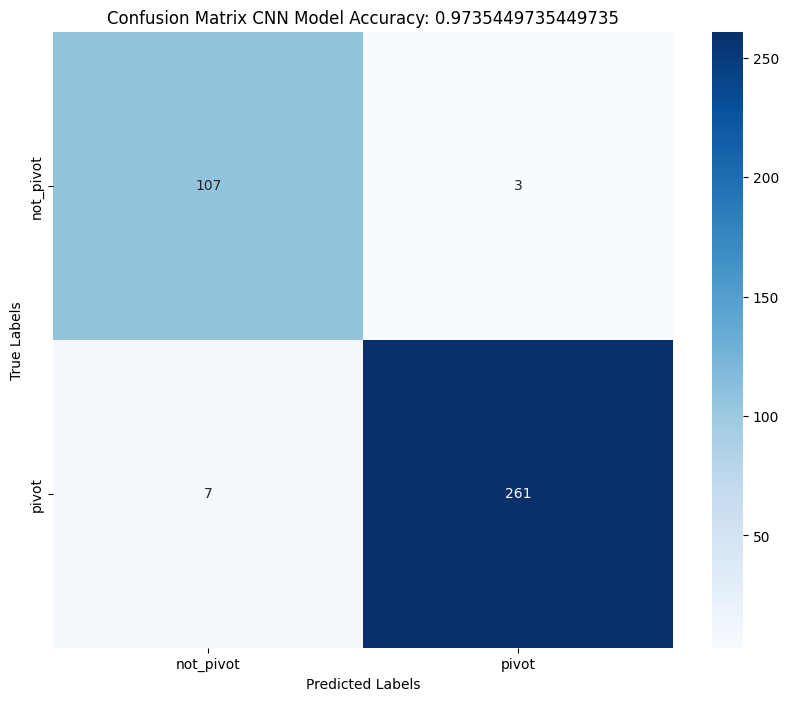

In [ ]:
true_labels = preds['true_label']
predictions = preds['prediction']
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix CNN Model Accuracy: {accuracy_score(true_labels, predictions)}')
plt.show()

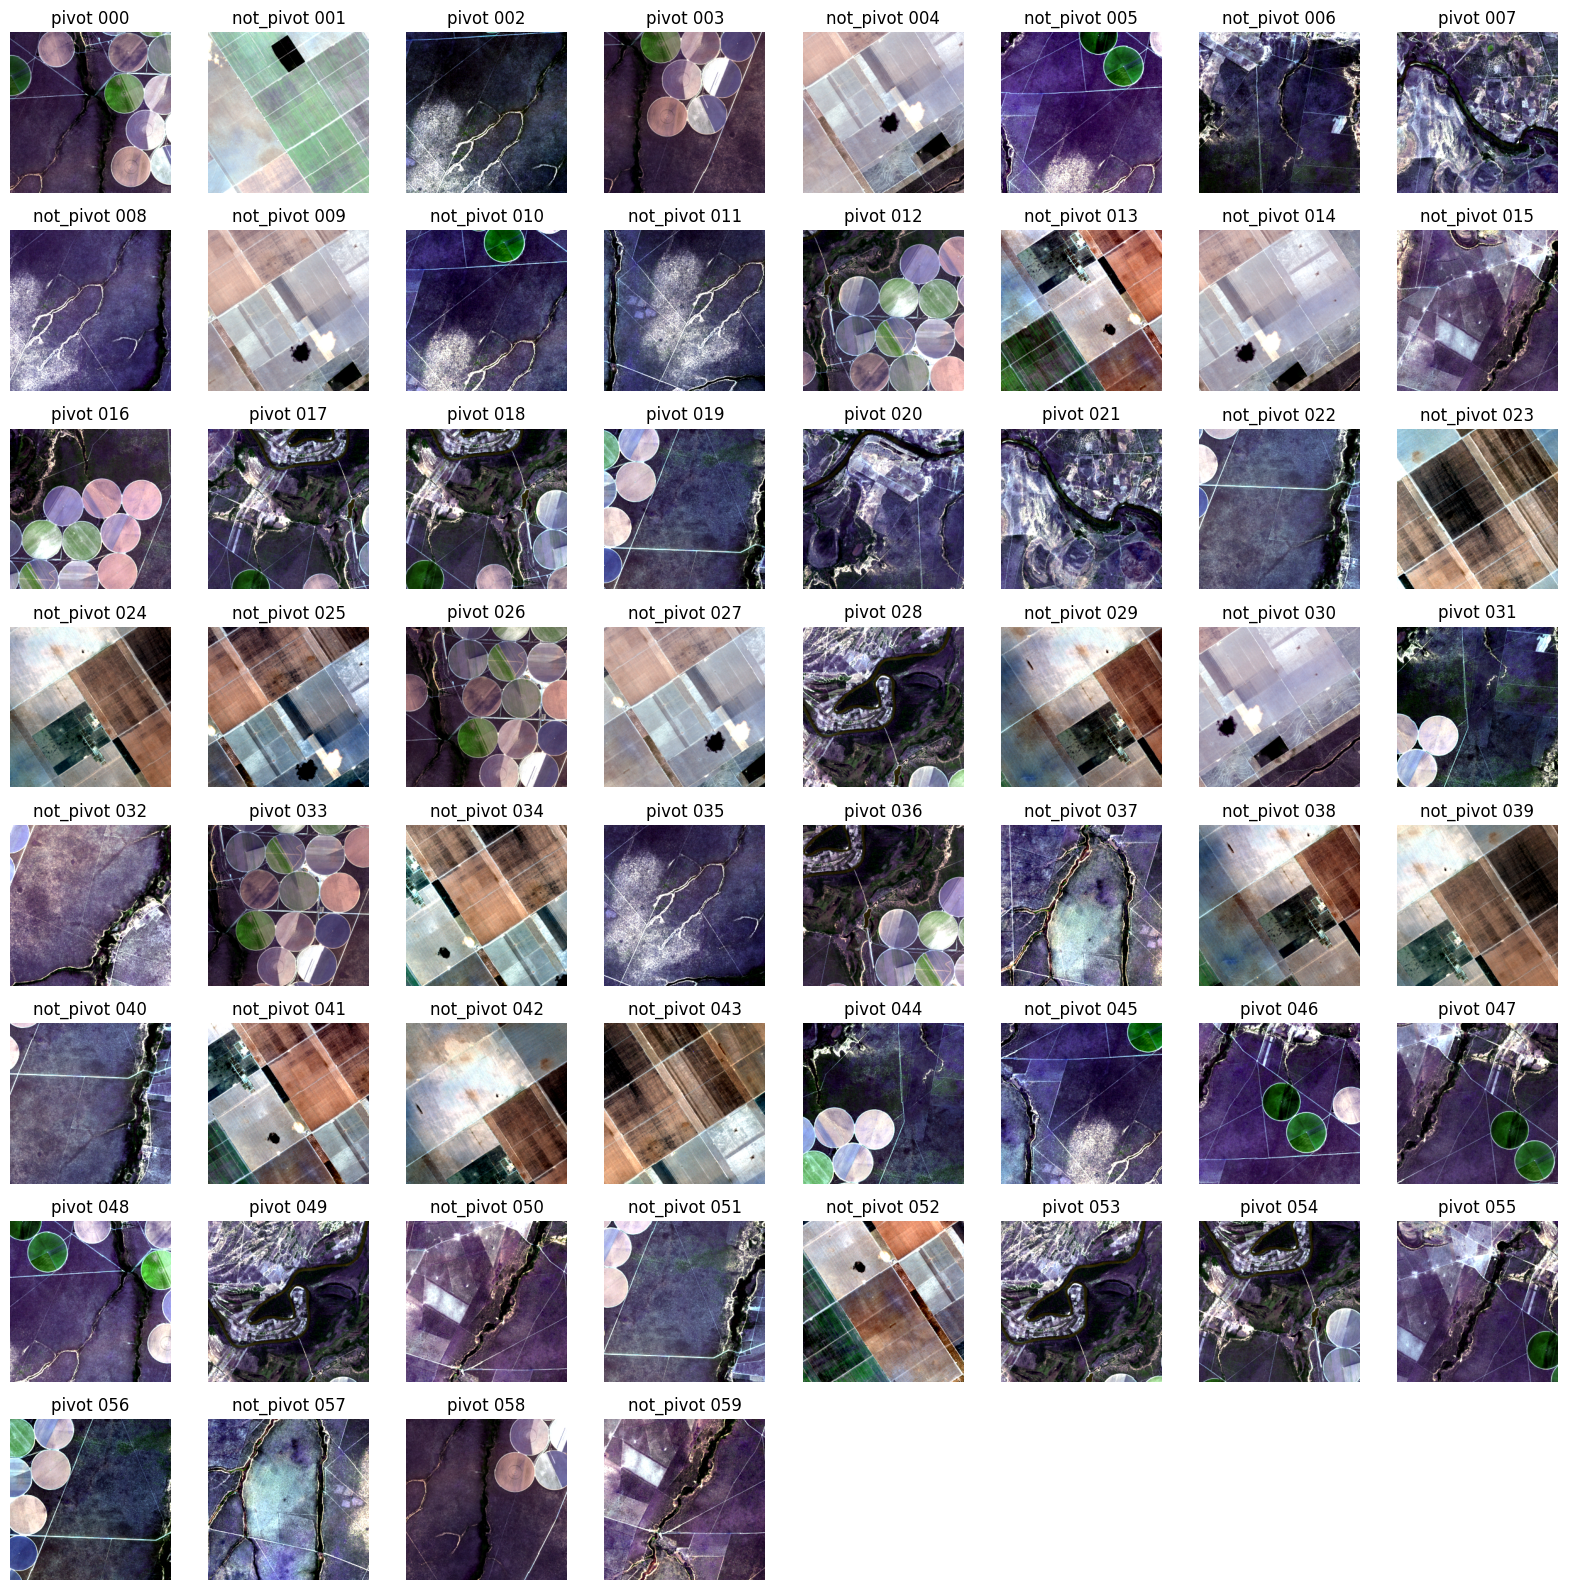

In [ ]:
def predict_images_in_folder(folder_path, model):
    images = []
    predictions = []
    number_images = []
    # Loop through all images in the folder
    for image_name in sorted(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)

        # Predict the label for each image
        prediction = predict_image(image_path, model)
        predictions.append(prediction)

        # Load the image for displaying
        image = Image.open(image_path)
        images.append(image)
        number_images.append(image_path[-7:-4])
    # Determine the grid size
    n_images = len(images)
    grid_size = int(n_images ** 0.5) + 1

    # Plot images with their predictions
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(n_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f'{predictions[i]} {number_images[i]}')
        axes[i].axis('off')

    # Hide any remaining empty subplots
    for i in range(n_images, grid_size * grid_size):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


folder_path = 'dataset-20240808T021407Z-001/dataset/teste'
predict_images_in_folder(folder_path, model)